In [12]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [13]:
h5 = 'cerberus_annot.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']

## Plotting

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [3]:
ca.triplets.source.unique()

array(['v29', 'v40', 'lapa', 'gtex', 'all', 'obs_det', 'sample_det',
       'obs_major', 'sample_major', 'obs_mm_det'], dtype=object)

In [4]:
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'

mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']
mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
subset = {'source': ['v40', 'obs_det', 'sample_major']}

0.4
12.0
(2.1431999999999998, 2.0)


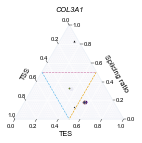

In [6]:
# COL3A1
subset = {'source': ['v40', 'obs_det', 'sample_det']}
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL3A1',
            hue='sample',
            cmap=c_dict,
            density=True,
            density_scale=50,
            density_cmap='Purples',
            density_vmax=7,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset={'source': ['v40', 'obs_det', 'sample_major']},
            size_scale=0.2,
            fname='figures/simplex_col3a1_major.pdf')

In [ ]:
def make_plots(ca, gname):
    fname = 'figures/{}_simplex.pdf'.format(gname.lower())
    subset = {'source': ['v40', 'obs_det', 'sample_det']}    
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gname,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                fname=fname)
    fname = 'figures/{}_simplex_major.pdf'.format(gname.lower())
    subset = {'source': ['v40', 'obs_det', 'sample_major']}    
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gname,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                fname=fname)    

In [7]:
# gnames = ['TCF4', 'TCF12', 'CTCF', 'MEF2D', 'MEF2A']
# for g in gnames:
#     make_plots(ca, g)

In [8]:
# # HOX genes
# temp = ca.plot_simplex(top='splicing_ratio',
#             subset={'source': 'sample_major', 'hox_gene': True},
#             density=True,
#             density_scale=20,
#             density_cmap='Purples',
#             log_density=True,
#             sectors=True,
#             scatter=True,
#             size='gene_tpm', 
#             log_size=True,
#             hue='sample',
#             cmap=c_dict,
#             jitter=True,
#             legend=False,
#             title='HOX genes in each sample',
#             opref='figures/hox_sample_major_density.pdf')

In [6]:
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
subset = {'source': ['v40', 'obs_det', 'sample_det']}

In [7]:
ca.triplets['hox_gene'] = ca.triplets.gname.str.startswith('HOX')

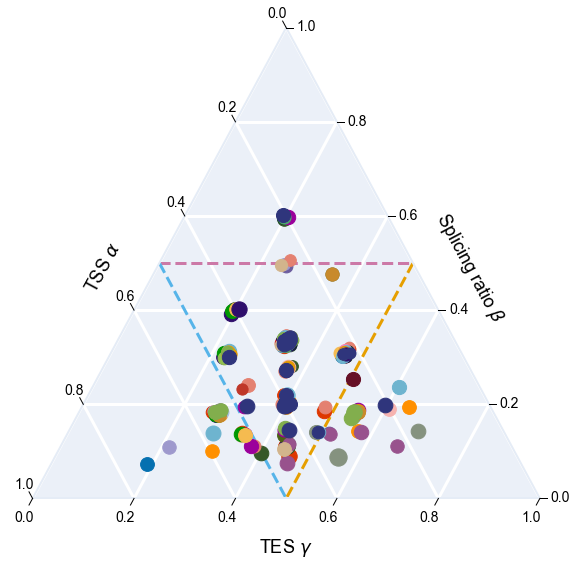

In [8]:
# HOX genes
df = ca.plot_simplex(top='splicing_ratio', 
            sectors=True,
            density=True, 
            scatter=False,
            subset={'source': 'sample_det', 'hox_gene': True},
            fname='figures/hox.pdf')

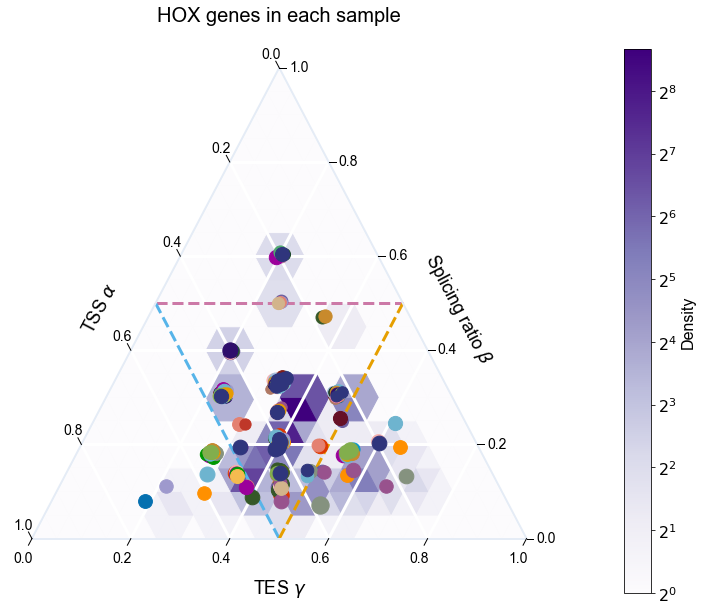

In [8]:
# HOX genes
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_det', 'hox_gene': True},
            density=True,
            density_scale=20,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=True,
            size='gene_tpm', 
            log_size=True,
            hue='sample',
            cmap=c_dict,
            jitter=True,
            legend=False,
            title='HOX genes in each sample',
            opref='figures/hox_sample_density.pdf')

0.4
12.0
(2.1431999999999998, 2.0)


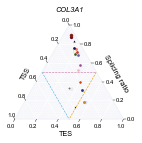

In [7]:
# COL3A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL3A1',
            hue='sample',
            cmap=c_dict,
            density=True,
            density_scale=50,
            density_cmap='Purples',
            density_vmax=7,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            size_scale=.2,
            fname='figures/simplex_col3a1.pdf')

10
300
(10.716, 10)


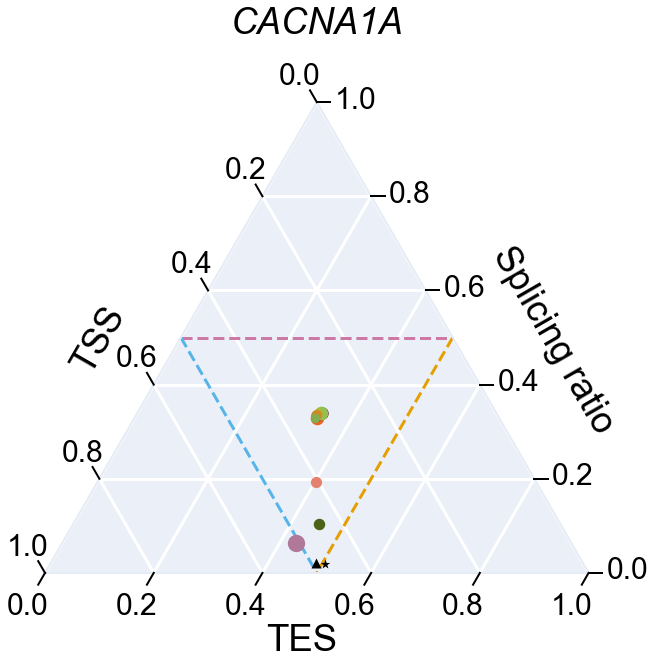

In [17]:
# CACNA1A
df = ca.plot_simplex(top='splicing_ratio', 
            gene='CACNA1A',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/cacna1a.pdf')

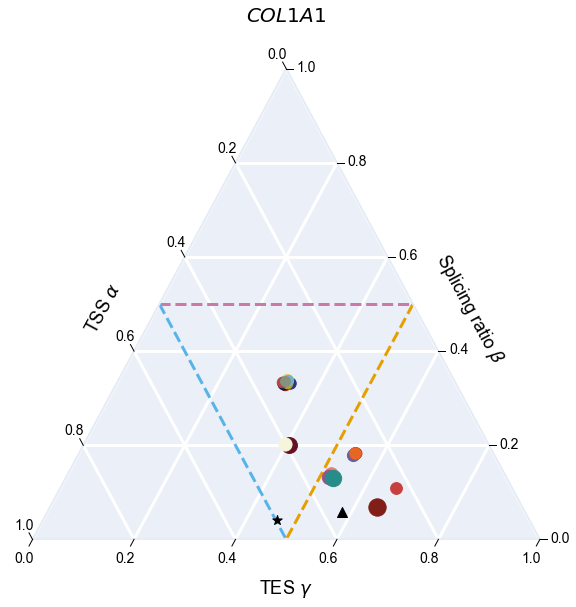

In [7]:
# COL1A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL1A1',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/col1a1.pdf')

0.4
12.0
(2.1431999999999998, 2.0)


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


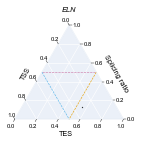

In [11]:
# ELN
df = ca.plot_simplex(top='splicing_ratio', 
            gene='ELN',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset={'source': 'v40'},
            size_scale=0.2,
            fname='figures/simplex_blank.pdf')

0.4
12.0
(2.1431999999999998, 2.0)


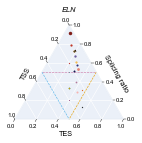

In [12]:
# ELN
df = ca.plot_simplex(top='splicing_ratio', 
            gene='ELN',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            size_scale=0.2,
            fname='figures/simplex_eln.pdf')

0.4
12.0
(2.1431999999999998, 2.0)


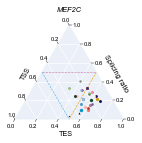

In [13]:
# MEF2C
df = ca.plot_simplex(top='splicing_ratio', 
            gene='MEF2C',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            size_scale=0.2,
            fname='figures/simplex_mef2c.pdf')

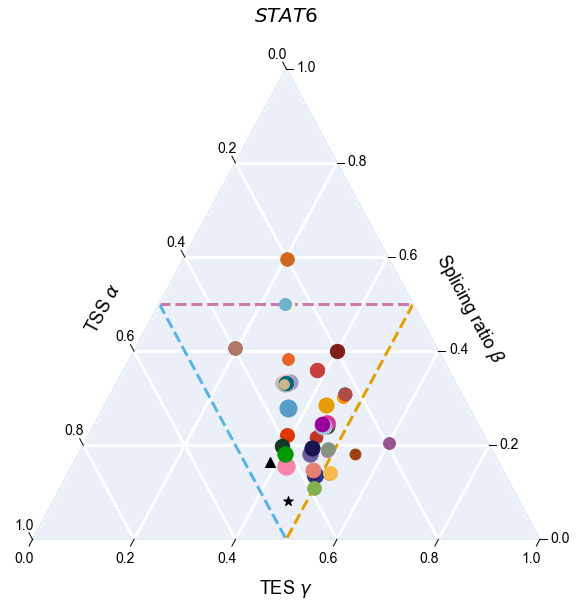

In [10]:
# STAT6
df = ca.plot_simplex(top='splicing_ratio', 
            gene='STAT6',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/stat6.pdf')

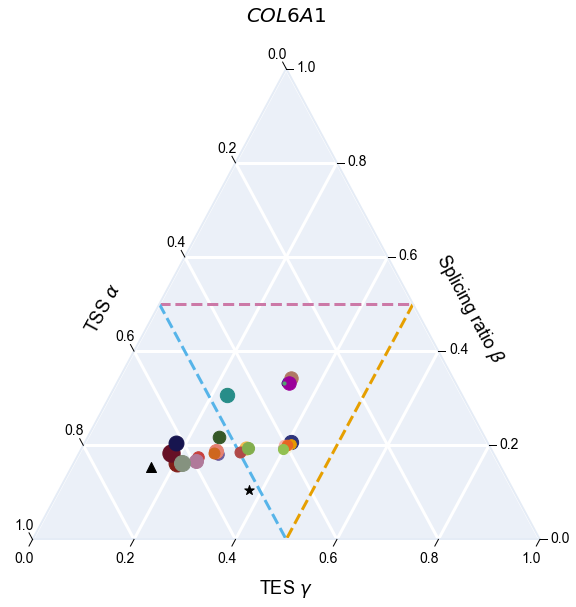

In [11]:
# COL6A1
df = ca.plot_simplex(top='splicing_ratio', 
            gene='COL6A1',
            hue='sample',
            cmap=c_dict,
            size='gene_tpm', 
            log_size=True,
            sectors=True,
            marker_style='source',
            mmap=mmap,
            legend=False,
            jitter=True,
            subset=subset,
            fname='figures/col6a1.pdf')

In [14]:
def get_sector_colors(cats=None):
    tss = '#56B4E9'
    tes = '#E69F00'
    splicing = '#CC79A7'
    simple = '#e5ecf6'
    c_dict = {'tss': tss,
              'splicing': splicing,
              'tes': tes,
              'simple': simple, 
              'mixed': '#b7b7b7'}
    order = ['tss', 'splicing', 'tes', 'mixed', 'simple']
    
    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

def plot_sector_gene_counts(counts):
    temp = pd.DataFrame()
    for source in counts.source.unique():
        df = assign_gisx_sector(counts)
        df = df.loc[df.source == source]
        df = df[['gid', 'source', 'sector']].groupby(['source', 'sector']).count().reset_index()
        df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
        df['total_genes'] = df.n_genes.sum()
        temp = pd.concat([temp, df])
    temp['perc'] = (temp.n_genes/temp.total_genes)*100
    # temp = temp.loc[temp.sector != 'simple'] 
    
    y = '% of total genes'
    temp.rename({'perc': y}, axis=1, inplace=True)
    c_dict, order = get_sector_colors(['tss', 'splicing', 'tes', 'mixed', 'simple'])
    # plot both together
    sns.set_context('paper', font_scale=1.8)
    ax = sns.catplot(data=temp, x='source',
                y=y, hue='sector', kind='bar',
                palette=c_dict, saturation=1,
                hue_order=order)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
    #         x = p.get_x() + p.get_width() / 2 - 0.45
            x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.00625
            ax.annotate(percentage, (x, y), size = 12)

    a = ax.axes[0,0]
    add_perc_2(a)
    
    return temp   

In [15]:
ca.triplets.source.unique()

array(['gtex', 'v40', 'v29', 'lapa', 'all', 'obs_det', 'sample_det',
       'obs_major', 'sample_major', 'obs_mm_det'], dtype=object)

## Density triplets / gisx assignments

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = 'cerberus_annot.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']

In [3]:
ca = cerberus.read('cerberus_annot_triplets.h5')

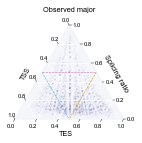

In [4]:
# Observed major isos
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'obs_major'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed major',
            size_scale=0.2,
            density_cbar=False,
            fname='figures/simplex_obs_major.pdf')

In [5]:
temp = assign_gisx_sector(temp)
beep = temp

In [6]:
beep.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,total,tss_ratio,tes_ratio,top_ratio,spl_ratio,sector
0,obs_major,ENSG00000000003,1.0,5.0,5.0,12.0,1.666667,TSPAN6,NaN,NaN,7.666667,0.130435,0.652174,21.739130,0.217391,tes
1,obs_major,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,TNMD,NaN,NaN,3.000000,0.333333,0.333333,33.333333,0.333333,simple
2,obs_major,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,DPM1,NaN,NaN,8.200000,0.243902,0.365854,39.024390,0.390244,mixed
3,obs_major,ENSG00000000457,1.0,3.0,3.0,5.0,1.500000,SCYL3,NaN,NaN,5.500000,0.181818,0.545455,27.272727,0.272727,tes
4,obs_major,ENSG00000000460,2.0,4.0,6.0,10.0,2.000000,C1orf112,NaN,NaN,8.000000,0.250000,0.500000,25.000000,0.250000,mixed


In [7]:
# plot_sector_gene_counts(temp)

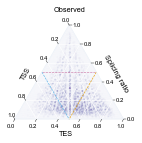

In [8]:
# Observed
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'obs_det'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed',
            size_scale=0.2,
            density_cbar=False,
            fname='figures/simplex_obs_det.pdf')

In [9]:
temp = assign_gisx_sector(temp)
beep = pd.concat([temp, beep])


In [10]:
# plot_sector_gene_counts(temp)

In [11]:
# # gencode v40
# temp = ca.plot_simplex(top='splicing_ratio',
#             subset={'source': 'v40'},
#             density=True,
#             density_scale=100,
#             density_cmap='Purples',
#             log_density=True,
#             sectors=True,
#             scatter=False,
#             legend=False,
#             title='GENCODE v40',
#             fname='figures/simplex_v40.png')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1599: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1598: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 33772


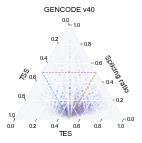

In [12]:
# gencode v40 from detected polya genes only
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   gene_subset='polya',
                   min_tpm=1)

temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'v40', 'gid': inds},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='GENCODE v40',
            size_scale=0.2,
            density_cbar=False,
            fname='figures/simplex_v40_det.pdf')

In [13]:
temp = assign_gisx_sector(temp)
beep = pd.concat([temp, beep])

In [14]:
# plot_sector_gene_counts(temp)

In [15]:
beep[['source', 'gid']].groupby('source').count()

,gid
source,
obs_det,26781
obs_major,26781
v40,33772


In [16]:
counts = beep
temp = pd.DataFrame()
for source in counts.source.unique():
    df = assign_gisx_sector(counts)
    df = df.loc[df.source == source]
    df = df[['gid', 'source', 'sector']].groupby(['source', 'sector']).count().reset_index()
    df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    df['total_genes'] = df.n_genes.sum()
    temp = pd.concat([temp, df])
temp['perc'] = (temp.n_genes/temp.total_genes)*100

In [17]:
temp

,source,sector,n_genes,total_genes,perc
0,v40,mixed,14574,33772,43.154092
1,v40,simple,11506,33772,34.069643
2,v40,splicing,438,33772,1.296932
3,v40,tes,5515,33772,16.330096
4,v40,tss,1739,33772,5.149236
0,obs_det,mixed,9288,26781,34.681304
1,obs_det,simple,8633,26781,32.235540
2,obs_det,splicing,946,26781,3.532355
3,obs_det,tes,5417,26781,20.227027
4,obs_det,tss,2497,26781,9.323774


In [18]:
temp.to_csv('genes_per_sector.tsv', sep='\t', index=False)

In [19]:
temp = pd.read_csv('genes_per_sector.tsv', sep='\t')

<Figure size 216x1440 with 0 Axes>

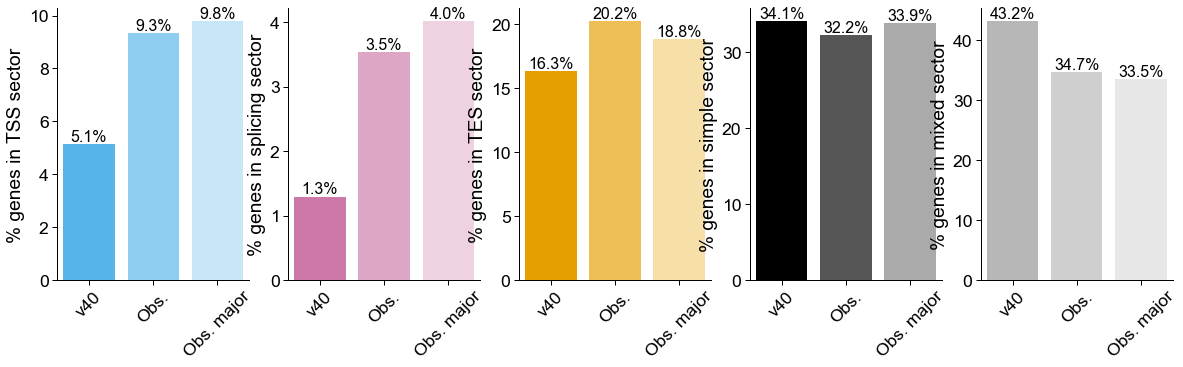

In [20]:
cat1 = 'sector'
cat2 = 'source'
cat2_order = ['v40', 'obs_det', 'obs_major']
cat1_order = ['tss', 'splicing', 'tes', 'simple', 'mixed']
parent_c_dict, parent_order = get_sector_colors()

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,20))
fig, axes = plt.subplots(1, len(cat1_order), figsize=(20,5))


# #create chart in each subplot
# sns.boxplot(data=df, x='team', y='points', ax=axes[0,0])
# sns.boxplot(data=df, x='team', y='assists', ax=axes[0,1])

# loop through first category
for i, c1 in enumerate(cat1_order):
    beep = temp.loc[temp[cat1] == c1]
    
    c = parent_c_dict[c1]
    c_dict, order = get_shade_colors(c, cat2_order)
    
    # plotting
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    # plt.figure(figsize=(3,4))

    ax = sns.barplot(data=beep, y='perc', x=cat2,
                     palette=c_dict, order=order,
                     saturation=1, ax=axes[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    if c1 in ['tss', 'tes']:
        c1 = c1.upper()
    ylabel = '% genes in {} sector'.format(c1)

    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.tick_params(axis="x", rotation=45)    
    ax.set_xticklabels(['v40', 'Obs.', 'Obs. major'])
    fname = 'figures/genes_{}_by_sector.pdf'.format(c1)
    
    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            # x = p.get_x() + p.get_width() / 2 - 0.3
            # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')


    add_perc_2(ax)
fname = 'figures/genes_by_sector.pdf'
# plt.show()
# plt.subplots_adjust(wspace=0.35)
# plt.tight_layout()
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")
    

## Why are there fewer genes overall in obs major vs. obs? 


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

h5 = 'cerberus_annot.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']

In [2]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [3]:
df = ca.triplets.copy(deep=True)

In [4]:
obs_det = df.loc[df.source == 'obs_det']
obs_major = df.loc[df.source == 'obs_major']

In [5]:
obs_det.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
0,obs_det,ENSG00000000003,1.0,6.0,9.0,28.0,2.571429,TSPAN6,NaN,NaN
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,TNMD,NaN,NaN
2,obs_det,ENSG00000000419,2.0,4.0,9.0,15.0,3.000000,DPM1,NaN,NaN
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,SCYL3,NaN,NaN
4,obs_det,ENSG00000000460,3.0,4.0,7.0,15.0,2.000000,C1orf112,NaN,NaN


In [6]:
obs_major.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
0,obs_major,ENSG00000000003,1.0,5.0,5.0,12.0,1.666667,TSPAN6,NaN,NaN
1,obs_major,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,TNMD,NaN,NaN
2,obs_major,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,DPM1,NaN,NaN
3,obs_major,ENSG00000000457,1.0,3.0,3.0,5.0,1.500000,SCYL3,NaN,NaN
4,obs_major,ENSG00000000460,2.0,4.0,6.0,10.0,2.000000,C1orf112,NaN,NaN


In [7]:
det_gids = obs_det.gid.unique().tolist()
major_gids = obs_major.gid.unique().tolist()

# there are only different genes in the obs_det set; not obs_major
print(len(list(set(det_gids)-set(major_gids))))
print(len(list(set(major_gids)-set(det_gids))))

0
0


In [15]:
miss_gids = list(set(det_gids)-set(major_gids))
miss_gids[:5]

['ENSG00000149932',
 'ENSG00000167635',
 'ENSG00000161526',
 'ENSG00000231513',
 'ENSG00000141027']

In [16]:
mj = pd.read_csv(major_set, sep='\t')

In [17]:
mj.loc[mj.gid.str.contains('ENSG00000149932')]

,tid,gname,gid,sample,pi,pi_rank,max_total_pi_x,max_total_pi_y


In [37]:
# recreation of get_major_isos

In [18]:
sg = swan.read('swan/swan.p')
t_df = pd.read_csv(filt_ab, sep='\t')
obs_col = 'sample'
min_tpm=1

Read in graph from swan/swan.p


In [19]:
t_df = t_df[['annot_gene_name', 'annot_transcript_id', 'annot_gene_id']]
t_df.rename({'annot_gene_name': 'gname',
             'annot_gene_id': 'gid',
             'annot_transcript_id': 'tid'}, 
             axis=1, 
             inplace=True)

df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col=obs_col)
df = df.sparse.to_dense().transpose()
tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col, how='max').sparse.to_dense().transpose()
tpm_df.reset_index(inplace=True)
tpm_df.rename({'index':'tid'}, axis=1, inplace=True)

# melt to have one entry per tid / sample combination
def melt_transcript_sample(df, t_df, obs_col, col_name):
    df = df.merge(t_df[['tid', 'gname', 'gid']], how='inner', on='tid')
    df.set_index(['tid', 'gname', 'gid'], inplace=True)
    df = df.melt(ignore_index=False, value_name=col_name, var_name=obs_col)
    df = df.dropna(subset=[col_name])
    df.reset_index(inplace=True)
    return df 

df = melt_transcript_sample(df, t_df, obs_col, col_name='pi')
tpm_df = melt_transcript_sample(tpm_df, t_df, obs_col, col_name='tpm')    

# add tpm info in and subset based on tpm thresh
df = df.merge(tpm_df, how='left', on=['tid', 'gname', 'gid', 'sample'])
print(df.loc[(df.tpm < min_tpm)&(df.pi > 0)].head())

                       tid       gname                gid sample         pi  \
2   ENSG00000227232[1,4,1]      WASH7P  ENSG00000227232.5  caco2  11.111112   
9   ENSG00000279457[1,1,2]  FO538757.1  ENSG00000279457.4  caco2   1.041667   
12  ENSG00000279457[2,3,1]  FO538757.1  ENSG00000279457.4  caco2   1.041667   
13  ENSG00000279457[2,3,2]  FO538757.1  ENSG00000279457.4  caco2   1.041667   
21  ENSG00000279457[2,8,2]  FO538757.1  ENSG00000279457.4  caco2   1.041667   

         tpm  
2   0.865904  
9   0.865904  
12  0.865904  
13  0.865904  
21  0.865904  


In [20]:
df.loc[df.gid.str.contains('ENSG00000149932')]

,tid,gname,gid,sample,pi,tpm
134070,"ENSG00000149932[1,1,1]",TMEM219,ENSG00000149932.16,caco2,21.212122,15.033932
134071,"ENSG00000149932[1,10,1]",TMEM219,ENSG00000149932.16,caco2,1.515152,1.731807
134072,"ENSG00000149932[1,11,1]",TMEM219,ENSG00000149932.16,caco2,0.000000,0.000000
134073,"ENSG00000149932[1,12,1]",TMEM219,ENSG00000149932.16,caco2,0.000000,0.000000
134074,"ENSG00000149932[1,13,1]",TMEM219,ENSG00000149932.16,caco2,0.757576,0.865904
...,...,...,...,...,...,...
8732791,"ENSG00000149932[2,2,1]",TMEM219,ENSG00000149932.16,kidney,0.000000,0.000000
8732792,"ENSG00000149932[3,10,1]",TMEM219,ENSG00000149932.16,kidney,1.030928,2.148551
8732793,"ENSG00000149932[3,16,1]",TMEM219,ENSG00000149932.16,kidney,0.000000,0.000000
8732794,"ENSG00000149932[3,4,1]",TMEM219,ENSG00000149932.16,kidney,25.773195,53.713768


In [21]:
temp = df.loc[df.tpm >= min_tpm]

In [22]:
temp.loc[temp.gid.str.contains('ENSG00000149932')]

,tid,gname,gid,sample,pi,tpm
134070,"ENSG00000149932[1,1,1]",TMEM219,ENSG00000149932.16,caco2,21.212122,15.033932
134071,"ENSG00000149932[1,10,1]",TMEM219,ENSG00000149932.16,caco2,1.515152,1.731807
134075,"ENSG00000149932[1,14,1]",TMEM219,ENSG00000149932.16,caco2,30.303032,19.042980
134076,"ENSG00000149932[1,15,1]",TMEM219,ENSG00000149932.16,caco2,1.515152,1.002262
134080,"ENSG00000149932[1,4,1]",TMEM219,ENSG00000149932.16,caco2,1.515152,1.002262
...,...,...,...,...,...,...
8732786,"ENSG00000149932[1,16,1]",TMEM219,ENSG00000149932.16,kidney,1.030928,2.148551
8732788,"ENSG00000149932[1,3,2]",TMEM219,ENSG00000149932.16,kidney,1.030928,2.148551
8732789,"ENSG00000149932[1,4,1]",TMEM219,ENSG00000149932.16,kidney,5.154639,10.742754
8732792,"ENSG00000149932[3,10,1]",TMEM219,ENSG00000149932.16,kidney,1.030928,2.148551


In [ ]:
# stuff used for obs_det set

In [32]:
df.loc[df.gid.str.contains('ENSG00000269471')]

,tid,gname,gid,sample,pi
2839181,"ENSG00000269471[1,1,1]",AC092329.2,ENSG00000269471.1,hl60_m2_24hr,100.0


In [14]:
temp = pd.read_csv(filt_ab, sep='\t')
temp, tids = get_tpm_table(temp,
               how='iso',
               min_tpm=1)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1599: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1598: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Number of isos reported: 212911


In [16]:
temp = temp.loc[temp.index.str.contains('ENSG00000171595')].transpose()

In [19]:
temp.loc[temp['ENSG00000171595[1,1,1]']>0]

annot_transcript_id,"ENSG00000171595[1,1,1]"
lower_lobe_of_right_lung_1_1,2.343729
lower_lobe_of_left_lung_2_1,6.594465


## Mouse match triplets -- need to rewrite

In [124]:
# # reference + mouse match expressed triplets
# e_trip = pd.read_csv('expressed_triplets.tsv', sep='\t')
# s_trip = pd.read_csv('mouse_match_triplets.tsv', sep='\t')

# # for now, hack together dfs to work with existing code
# e_trip.rename({'sample': 'source'}, axis=1, inplace=True)
# trips = pd.concat([s_trip, e_trip])
# trips.loc[trips.source == 'lapa', 'source'] = 'obs'
# trips.loc[trips.source=='all', 'source'] = 'cerberus'

# mm_tissues = ['adrenal gland', 'heart', 'muscle', 'brain', 'pgp1_excite_neuron', 'pgp1_astro', 'h9_osteocyte']
# mm_annot = ['cerberus', 'v40', 'v29', 'all']
# mm_sources = mm_tissues+mm_annot
# trips = trips.loc[trips.source.isin(mm_sources)]

In [46]:
trips.source.unique()

array(['heart', 'adrenal gland', 'brain', 'muscle', 'pgp1_astro',
       'h9_osteocyte', 'pgp1_excite_neuron'], dtype=object)

In [47]:
c_dict, order = get_biosample_colors()
c_dict['v29'] = 'k'
c_dict['obs'] = 'k'
c_dict['v40'] = 'k'
c_dict['cerberus'] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs': '^', 'cerberus': '2'}

[array([10.]), array([38.18947019]), array([114.11288002]), array([300.])]


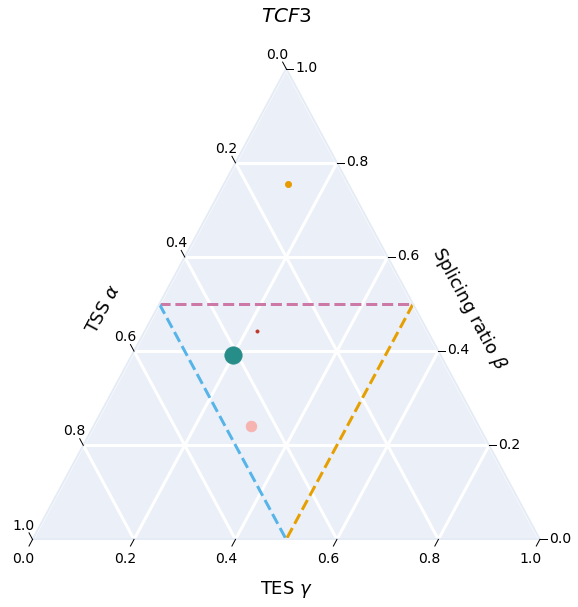

In [48]:
# TCF3
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, array([77.14291214]), array([131.02573768])]


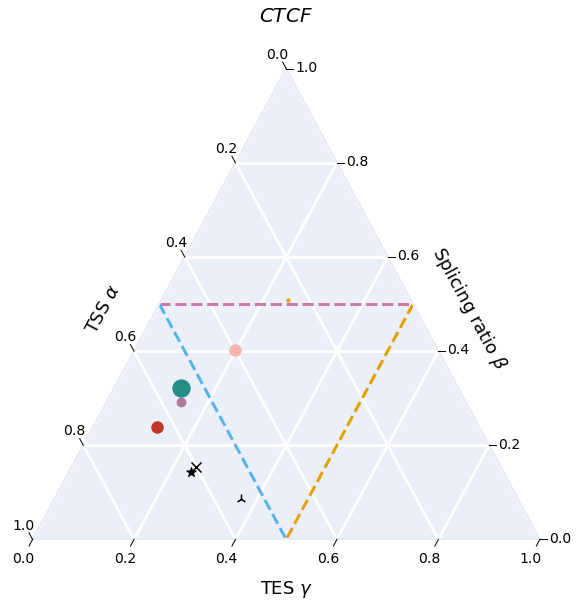

In [60]:
# TCF3
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='CTCF',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, array([10.]), array([109.86794417])]


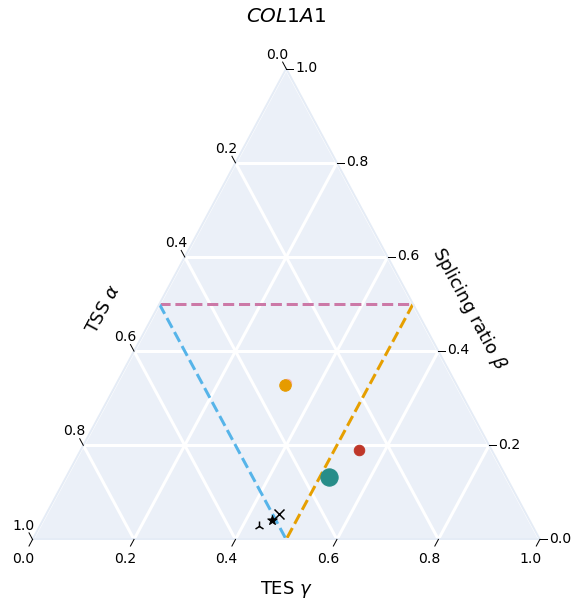

In [35]:
# COL1A1
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

In [30]:
trips.loc[trips.gname =='COL1A1']

,Unnamed: 0,gid,n_tss,n_tes,n_ic,source,splicing_ratio,gname,n_iso,gene_tpm
39947,39947,ENSG00000108821,12.0,11.0,13.0,v40,1.130435,COL1A1,13.0,NaN
101491,101491,ENSG00000108821,12.0,11.0,13.0,v29,1.130435,COL1A1,13.0,NaN
160695,160695,ENSG00000108821,20.0,16.0,15.0,cerberus,0.833333,COL1A1,0.0,NaN
55689,55689,ENSG00000108821,1.0,1.0,1.0,brain,1.000000,COL1A1,1.0,2.852873
180963,180963,ENSG00000108821,1.0,2.0,1.0,heart,0.666667,COL1A1,2.0,57.795326
471228,471228,ENSG00000108821,1.0,1.0,1.0,muscle,1.000000,COL1A1,1.0,18.003805
483372,483372,ENSG00000108821,1.0,1.0,1.0,adrenal gland,1.000000,COL1A1,1.0,110.667440


In [389]:
trip_df = get_expressed_triplets(c_annot, sg, obs_col='sample', min_tpm=1)

In [390]:
trip_df.head()

,gid,sample,tid,n_tss,n_ic,n_tes,gene_tpm,splicing_ratio,gname
0,ENSG00000000003,hepg2,6,1,3,4,191.014984,1.2,TSPAN6
1,ENSG00000000419,hepg2,6,1,6,2,62.502338,4.0,DPM1
2,ENSG00000000457,hepg2,1,1,1,1,3.207075,1.0,SCYL3
3,ENSG00000000460,hepg2,3,2,3,2,8.606131,1.5,C1orf112
4,ENSG00000001036,hepg2,7,1,5,4,282.548126,2.0,FUCA2


In [206]:
# calculate pi values to get weighted triplet
t_df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col=gb) # this boi is sparse

In [210]:
# add additional stuff to end adatas
sg.tss_adata.var['gene_id'] = sg.tss_adata.var['gid']
sg.tss_adata.var = add_stable_gid(sg.tss_adata.var)
sg.tss_adata.var = sg.tss_adata.var.merge(sg.loc_df[['chrom', 'coord']],
                                          how='left', left_on='vertex_id', 
                                          right_index=True)

In [326]:
def check_gene_sample(sample, gene):
    n_tss = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'tss_id'].unique())
    n_ic = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'ic_id'].unique())
    n_tes = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'tes_id'].unique())
    n_t = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene)].index.unique())
    
    print('Triplet for {}, {}: [{},{},{}]'.format(sample, gene, n_tss, n_ic, n_tes))
    print('n transcripts: {}'.format(n_t))


In [328]:
# check_gene_sample('hepg2', 'ENSG00000000003')

In [110]:
tss_map = c_annot.tss_map
tss_map = tss_map.loc[~tss_map.Name.isnull()]
tss_map['gene_id'] = tss_map.Name.str.split('_', expand=True)[0]
tss_map.loc[(tss_map.gene_id.isin(t))&(tss_map.source == 'v29')]

,Chromosome,Start,End,Strand,source,Name,gene_id
13224,chr1,11908096,11908197,+,v29,ENSG00000285646_2,ENSG00000285646
13225,chr1,11908101,11908202,+,v29,ENSG00000199347_1,ENSG00000199347
13249,chr1,12166892,12166993,+,v29,ENSG00000283789_1,ENSG00000283789
13510,chr1,16643058,16643159,-,v29,ENSG00000283773_1,ENSG00000283773
14056,chr1,25337414,25337515,-,v29,ENSG00000259984_1,ENSG00000259984
...,...,...,...,...,...,...,...
2484818,chrX,102599461,102599590,+,v29,ENSG00000271147_3,ENSG00000271147
2484821,chrX,147911771,147911872,+,v29,ENSG00000274086_2,ENSG00000274086
2484822,chrX,73944281,73944382,+,v29,ENSG00000274430_2,ENSG00000274430
2484823,chrX,155382064,155382165,+,v29,ENSG00000274791_1,ENSG00000274791


In [104]:
tes.loc[tes.gene_id == 'ENSG00000277577']

,gene_id,n_tes
54299,ENSG00000277577,1


In [88]:
tss.head()

,gene_id,n_tss
0,ENSG00000000003,3
1,ENSG00000000005,2
2,ENSG00000000419,2
3,ENSG00000000457,3
4,ENSG00000000460,5


In [83]:
tss = tss[['Name', 'gene_id']].groupby('gene_id').count().reset_index()
tss.rename({'Name

In [84]:
tss.head()

,Name
gene_id,
ENSG00000000003,3
ENSG00000000005,2
ENSG00000000419,2
ENSG00000000457,3
ENSG00000000460,5


## How many simple-appearing genes do we have? 

In [90]:
# reference + expressed triplets
trips = pd.read_csv('source_triplets.tsv', sep='\t')

In [91]:
trips = trips.loc[trips.source=='lapa_det']

In [92]:
trips.loc[trips.gname == 'KMT2A']

,gid,n_tss,n_tes,n_ic,source,n_iso,splicing_ratio,gname
222873,ENSG00000118058,10.0,10.0,10.0,lapa_det,12.0,1.0,KMT2A


In [93]:
trips = trips.loc[trips.n_tss == trips.n_tes]
trips = trips.loc[trips.n_ic == trips.n_tes]

In [94]:
trips.head()

,gid,n_tss,n_tes,n_ic,source,n_iso,splicing_ratio,gname
218239,ENSG00000000005,1.0,1.0,1.0,lapa_det,1.0,1.0,TNMD
218264,ENSG00000002746,1.0,1.0,1.0,lapa_det,1.0,1.0,HECW1
218271,ENSG00000003137,1.0,1.0,1.0,lapa_det,1.0,1.0,CYP26B1
218300,ENSG00000004846,1.0,1.0,1.0,lapa_det,1.0,1.0,ABCB5
218305,ENSG00000004939,1.0,1.0,1.0,lapa_det,1.0,1.0,SLC4A1


In [95]:
len(trips.index)

11999

In [97]:
trips = trips.loc[(trips.n_tss!=1)]
len(trips.index)

717

In [61]:
trips.groupby('n_tss').count()

,gid,n_tes,n_ic,source,n_iso,splicing_ratio,gname
n_tss,,,,,,,
2.0,512,512,512,512,512,512,512
3.0,137,137,137,137,137,137,137
4.0,33,33,33,33,33,33,33
5.0,18,18,18,18,18,18,18
6.0,11,11,11,11,11,11,11
7.0,3,3,3,3,3,3,3
8.0,2,2,2,2,2,2,2
10.0,1,1,1,1,1,1,1


In [66]:
trips.loc[trips.n_tss >= 7]

,gid,n_tss,n_tes,n_ic,source,n_iso,splicing_ratio,gname
220870,ENSG00000102781,7.0,7.0,7.0,lapa_det,15.0,1.0,KATNAL1
222873,ENSG00000118058,10.0,10.0,10.0,lapa_det,12.0,1.0,KMT2A
223372,ENSG00000122779,7.0,7.0,7.0,lapa_det,28.0,1.0,TRIM24
227135,ENSG00000150764,8.0,8.0,8.0,lapa_det,15.0,1.0,DIXDC1
234081,ENSG00000198081,8.0,8.0,8.0,lapa_det,45.0,1.0,ZBTB14
240464,ENSG00000244405,7.0,7.0,7.0,lapa_det,11.0,1.0,ETV5


In [69]:
gids = trips.loc[trips.n_tss>=7, 'gid'].tolist()
gids

['ENSG00000102781',
 'ENSG00000118058',
 'ENSG00000122779',
 'ENSG00000150764',
 'ENSG00000198081',
 'ENSG00000244405']

In [63]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=1)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1478: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1477: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 244103
# isos >= 1 tpm: 222246
Number of isos reported: 222246


In [73]:
tids = []
for gid in gids:
    tids+=df.loc[df.index.str.contains(gid)].index.tolist()

In [75]:
ca.t_map.head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source
0,ENST00000003912.7,2,ENSG00000001461_2,ENSG00000001461_1,1,ENSG00000001461_1,1,ENSG00000001461,NIPAL3,NIPAL3-201,"[1,2,1]","ENSG00000001461[1,2,1]","NIPAL3[1,2,1]",False,False,v29
1,ENST00000008440.9,3,ENSG00000010072_3,ENSG00000010072_1,1,ENSG00000010072_2,2,ENSG00000010072,SPRTN,SPRTN-201,"[1,3,2]","ENSG00000010072[1,3,2]","SPRTN[1,3,2]",False,False,v29
2,ENST00000009105.5,2,ENSG00000008118_2,ENSG00000008118_1,1,ENSG00000008118_1,1,ENSG00000008118,CAMK1G,CAMK1G-201,"[1,2,1]","ENSG00000008118[1,2,1]","CAMK1G[1,2,1]",False,False,v29
3,ENST00000010299.10,2,ENSG00000009780_2,ENSG00000009780_1,1,ENSG00000009780_3,3,ENSG00000009780,FAM76A,FAM76A-201,"[1,2,3]","ENSG00000009780[1,2,3]","FAM76A[1,2,3]",False,False,v29
4,ENST00000011700.10,6,ENSG00000048707_6,ENSG00000048707_5,5,ENSG00000048707_13,13,ENSG00000048707,VPS13D,VPS13D-201,"[5,6,13]","ENSG00000048707[5,6,13]","VPS13D[5,6,13]",False,False,v29


In [78]:
temp = ca.t_map.loc[ca.t_map.source=='lapa']
temp = temp.loc[temp.transcript_id.isin(tids)]

In [79]:
temp.head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source
47000,ENCODEHT000919949#0,10,ENSG00000150764_10,ENSG00000150764_9,9,ENSG00000150764_9,9,ENSG00000150764,DIXDC1,ENCODEHT000919949,"[9,10,9]","ENSG00000150764[9,10,9]","DIXDC1[9,10,9]",False,False,lapa
47001,ENCODEHT000919949#1,10,ENSG00000150764_10,ENSG00000150764_9,9,ENSG00000150764_2,2,ENSG00000150764,DIXDC1,ENCODEHT000919949,"[9,10,2]","ENSG00000150764[9,10,2]","DIXDC1[9,10,2]",False,False,lapa
47002,ENCODEHT000919949#2,10,ENSG00000150764_10,ENSG00000150764_1,1,ENSG00000150764_2,2,ENSG00000150764,DIXDC1,ENCODEHT000919949,"[1,10,2]","ENSG00000150764[1,10,2]","DIXDC1[1,10,2]",False,False,lapa
47113,ENCODEHT000937211#0,40,ENSG00000118058_40,ENSG00000118058_26,26,ENSG00000118058_29,29,ENSG00000118058,KMT2A,ENCODEHT000937211,"[26,40,29]","ENSG00000118058[26,40,29]","KMT2A[26,40,29]",False,False,lapa
49857,ENST00000392873.4,16,ENSG00000118058_16,ENSG00000118058_6,6,ENSG00000118058_12,12,ENSG00000118058,KMT2A,KMT2A-202,"[6,16,12]","ENSG00000118058[6,16,12]","KMT2A[6,16,12]",False,False,lapa


In [81]:
temp = temp.merge(ca.ic[['Name', 'novelty']].drop_duplicates(), how='left',
                  left_on='ic_id', right_on='Name')

In [86]:
print(len(temp.transcript_id.unique()))
print(len(tids))

126
126


In [88]:
temp = temp[['transcript_id', 'gene_id', 'gene_name', 'novelty']].drop_duplicates()

In [89]:
temp = temp[['transcript_id', 'novelty']]
temp.groupby('novelty').count()

,transcript_id
novelty,
ISM,20
Known,86
NIC,9
NNC,11
